In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/VaibhavData/Datasets/modified_xray_pneumonia.zip

In [3]:
EPOCHS = 30
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

In [4]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt

### Data Preparation

In [5]:
# Directory paths for train, validation, and test sets
train_dir = '/content/xray_pneumonia/train'
test_dir = '/content/xray_pneumonia/test'
val_dir = '/content/xray_pneumonia/val'

In [6]:
# Expand the single-channel greyscale image into three channels
def expand_greyscale_image_channels(image):
    return np.repeat(image[:, :, np.newaxis], 3, axis=-1)

# Data augmentation configuration
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

In [7]:
from itertools import chain

# Generate batches of augmented data for train, validation, and test sets
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='rgb'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='rgb'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False,
    color_mode='rgb'
)

Found 6505 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [8]:
print(train_generator.image_shape)
print("Number of images in train_generator:", train_generator.n)
print("Number of images in test_generator:", test_generator.n)
print("Number of images in val_generator:", val_generator.n)

(224, 224, 3)
Number of images in train_generator: 6505
Number of images in test_generator: 624
Number of images in val_generator: 16


### Model Training

In [9]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D

# Load the pre-trained ResNet50 model without including the top layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the weights of the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom top layers for pneumonia detection
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.1)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.1)(x)
predictions = Dense(1, activation='sigmoid')(x)

# Create the final ResNet50-based model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()


94765736/94765736 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                         

In [11]:
from tensorflow.keras.callbacks import ModelCheckpoint

# # Define the filepath to save the best model
# checkpoint_filepath = '/content/drive/MyDrive/VaibhavData/modelsV2/cnn/resnet50_pneumonia_detection.h5'

# # Define a callback to save the best model based on validation accuracy
# model_checkpoint_callback = ModelCheckpoint(
#     filepath=checkpoint_filepath,
#     save_best_only=True,
#     monitor='accuracy',
#     mode='max',
#     verbose=1
# )

# Train the model with the model checkpoint callback
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    # callbacks=[model_checkpoint_callback]  # Pass the callback to the fit method
)

Epoch 1/30
204/204 [==============================] - 110s 538ms/step - loss: 0.6101 - accuracy: 0.6872 - val_loss: 0.7618 - val_accuracy: 0.5000
Epoch 2/30
204/204 [==============================] - 109s 532ms/step - loss: 0.5335 - accuracy: 0.7251 - val_loss: 0.7058 - val_accuracy: 0.6250
Epoch 3/30
204/204 [==============================] - 108s 528ms/step - loss: 0.4991 - accuracy: 0.7499 - val_loss: 0.9452 - val_accuracy: 0.5625
Epoch 4/30
204/204 [==============================] - 109s 535ms/step - loss: 0.4867 - accuracy: 0.7551 - val_loss: 0.5788 - val_accuracy: 0.6875
Epoch 5/30
204/204 [==============================] - 108s 528ms/step - loss: 0.4671 - accuracy: 0.7737 - val_loss: 0.6418 - val_accuracy: 0.6250
Epoch 6/30
204/204 [==============================] - 108s 529ms/step - loss: 0.4545 - accuracy: 0.7799 - val_loss: 0.7824 - val_accuracy: 0.6250
Epoch 7/30
204/204 [==============================] - 108s 530ms/step - loss: 0.4219 - accuracy: 0.7985 - val_loss: 0.8838 -

In [12]:
# Save the trained model to the specified file path
model.save('/content/drive/MyDrive/VaibhavData/modelsV2/cnn/resnet50_pneumonia_detection_v2.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [13]:
# Evaluate the model on the train set
train_loss, train_accuracy = model.evaluate(train_generator)
print("Train Loss:", train_loss)
print("Train Accuracy:", train_accuracy)

204/204 [==============================] - 108s 528ms/step - loss: 0.3428 - accuracy: 0.8564
Train Loss: 0.3427809178829193
Train Accuracy: 0.8564181327819824


In [14]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

20/20 [==============================] - 5s 204ms/step - loss: 0.4494 - accuracy: 0.8093
Test Loss: 0.449390172958374
Test Accuracy: 0.8092948794364929


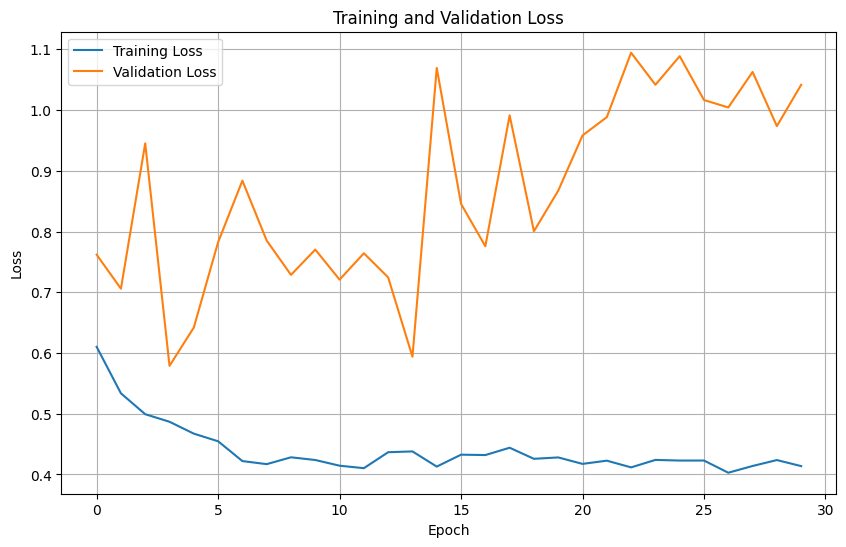

<function matplotlib.pyplot.show(close=None, block=None)>

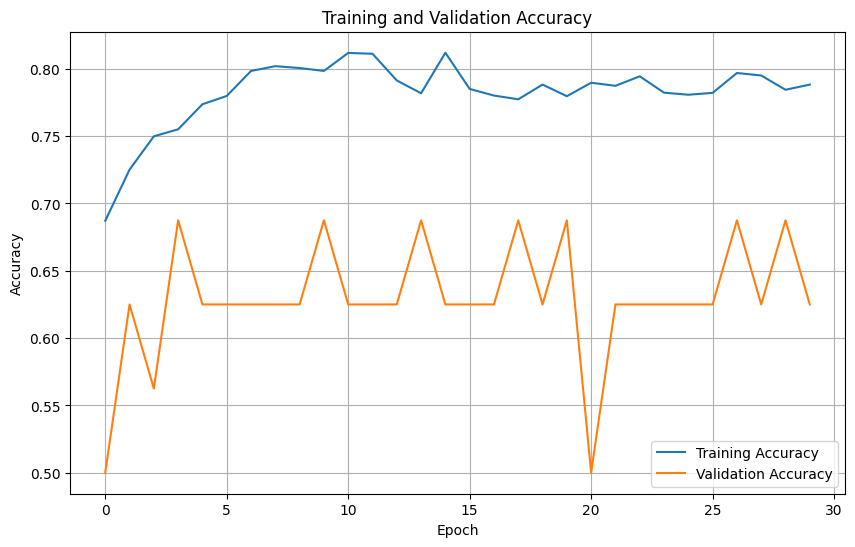

In [15]:
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig('/content/drive/MyDrive/VaibhavData/images/cnn_training_validation_loss_v2.png')
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.savefig('/content/drive/MyDrive/VaibhavData/images/cnn_training_validation_accuracy_v2.png')
plt.show

### Load model

In [9]:
# Load the saved model
import tensorflow as tf

model = tf.keras.models.load_model('/content/drive/MyDrive/VaibhavData/modelsV2/cnn/resnet50_pneumonia_detection_v2.h5')

In [10]:
# Evaluate the model on the train set
train_loss, train_accuracy = model.evaluate(train_generator)
print("Train Loss:", train_loss)
print("Train Accuracy:", train_accuracy)

204/204 [==============================] - 112s 526ms/step - loss: 0.3331 - accuracy: 0.8675
Train Loss: 0.33308103680610657
Train Accuracy: 0.8674865365028381


In [11]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

20/20 [==============================] - 5s 234ms/step - loss: 0.4482 - accuracy: 0.8109
Test Loss: 0.4482317566871643
Test Accuracy: 0.8108974099159241
